In [44]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MultipleLocator as ML
from matplotlib.ticker import ScalarFormatter as SF


In [45]:
algorithms = ['QMIX', 'VDN', 'DRQN']
exp_color_map = {
    'QMIX': 'C2',
    'VDN': 'C1',
    'DRQN': 'C4',
}
evaluation_path = {
    'QMIX': "./QMIX/24.10.03.14.12",
    'VDN': "./VDN/24.10.02.20.45",
    'DRQN': "./DRQN/24.10.03.19.08"
}
test_types = ['HinderOneAll', 'HinderOneGivenPeriod']
agents = ['influent_flowrate', '1st_stage_pump', '2nd_stage_pump']
agents_hindered = agents + ['None']
agents_hue = {
    'influent_flowrate': 'C3', '1st_stage_pump': 'C4', '2nd_stage_pump':'C8', 'None': 'C9'
}

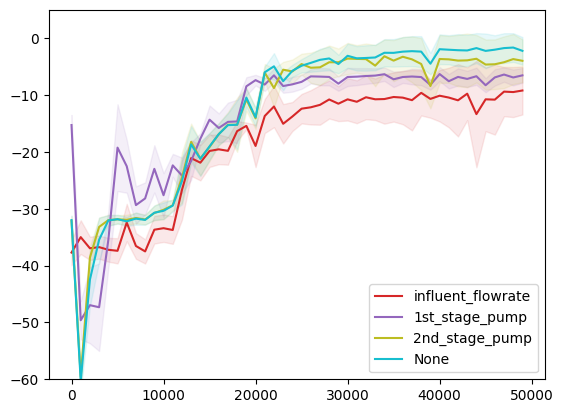

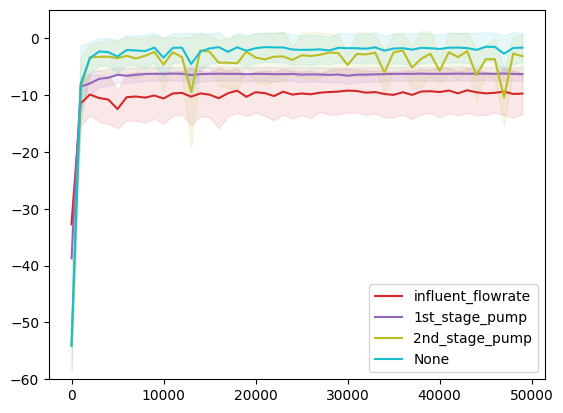

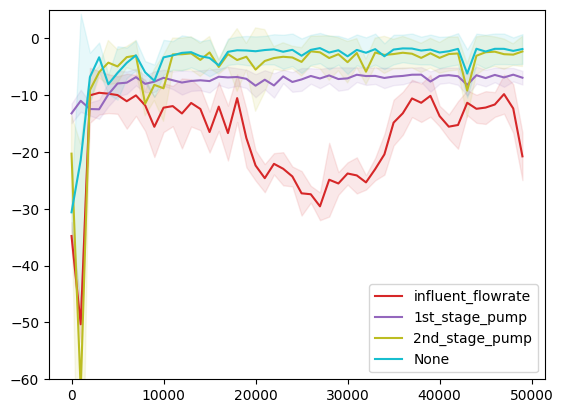

In [46]:
test = test_types[0]
# algorithm = algorithms[1]
plt.style.use('default')
raw_dfs = {}
summary_dfs = {}
for algorithm in algorithms:
    raw_dfs[algorithm] = pd.DataFrame()
    data_path = os.path.join(evaluation_path[algorithm], test)
    datas = os.listdir(data_path)
    datas = sorted(datas)
    reward_mean_log = []
    reward_std_log  = []
    episode_num_log = []
    agent_log       = []

    for i, data in enumerate(datas):
        data_parsed = data.split('_')
        # episode = int(data_parsed[0])
        data_df = pd.read_csv(os.path.join(data_path, data))

        episode = data_df['episode number'][0]
        # agent   = data_df['agent_hindered'][0]
        agent   = '_'.join(data_parsed[1:-1])
        data_df['agent_hindered'] = agent
        if i == 0:
            raw_dfs[algorithm] = data_df
        else:
            raw_dfs[algorithm] = pd.concat([raw_dfs[algorithm], data_df])
        
        reward_mean_log.append(np.mean(data_df['Reward sum']))
        reward_std_log.append(np.std(data_df['Reward sum']))
        episode_num_log.append(episode)
        agent_log.append(agent)
        
    summary_df = pd.DataFrame(
        {
            "episode": episode_num_log,
            "agent hindered": agent_log,
            "Mean reward":reward_mean_log,
            "Std reward": reward_std_log,
        }
    )
    summary_df = summary_df.sort_values(by='episode', ignore_index=True)
    summary_dfs[algorithm] = summary_df

    raw_dfs[algorithm] = raw_dfs[algorithm].sort_values(by='episode number', ignore_index=True)
    for a in agents_hindered:
        episodes    = np.array(summary_df[summary_df['agent hindered']==a]['episode'])
        mean_reward = np.array(summary_df[summary_df['agent hindered']==a]['Mean reward'])
        std_reward  = np.array(summary_df[summary_df['agent hindered']==a]['Std reward'])
        plt.plot(episodes, mean_reward, agents_hue[a], label=a)
        plt.ylim([-60.0, 5.0])
        plt.fill_between(x=episodes, y1=mean_reward-std_reward, y2=mean_reward+std_reward, color=agents_hue[a], alpha=0.1)

    plt.legend()
    plt.show()

In [47]:
violinplot_lower_ranges = np.arange(0, 49000, 10000)
violinplot_upper_ranges = violinplot_lower_ranges + 10000

episode_conditions = {}

for algorithm in algorithms:
    episode_conditions[algorithm] = [(raw_dfs[algorithm]['episode number'] >= violinplot_lower_ranges[i]) & (raw_dfs[algorithm]['episode number'] <= violinplot_upper_ranges[i]) for i,_ in enumerate(violinplot_lower_ranges)]

In [48]:
for algorithm in algorithms:
    raw_dfs[algorithm]["algorithm"] = algorithm
concat_df = pd.concat([raw_dfs['QMIX'], raw_dfs['VDN'], raw_dfs['DRQN']], ignore_index=True)
concat_df_episode_condition = [(concat_df['episode number'] >= violinplot_lower_ranges[i]) & (concat_df['episode number'] <= violinplot_upper_ranges[i]) for i,_ in enumerate(violinplot_lower_ranges)]
concat_df['episode_condition'] = ""

for i, episode_condition in enumerate(concat_df_episode_condition):
    # concat_df.loc[concat_df_episode_condition[i], 'episode_condition'] = f"{violinplot_lower_ranges[i]}\nto\n{violinplot_upper_ranges[i]}"
    concat_df.loc[concat_df_episode_condition[i], 'episode_condition'] = f"{violinplot_lower_ranges[i]} to {violinplot_upper_ranges[i]}"

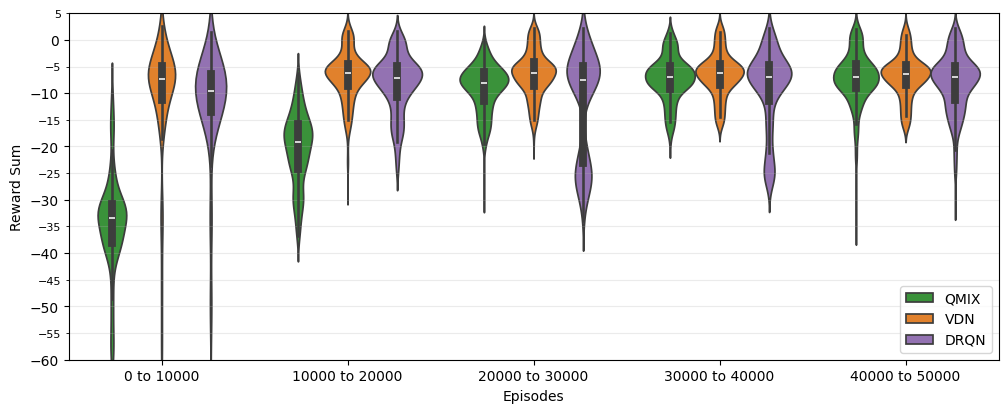

In [59]:
figure, ax = plt.subplots(figsize=(12.0, 4.5))
sns.violinplot(concat_df[concat_df['agent_hindered'] != 'None'], y='Reward sum', x='episode_condition',
                hue='algorithm', split=False, fill=True, ax=ax, palette=exp_color_map)
ax.yaxis.set_major_locator(ML(10.0))
ax.yaxis.set_minor_locator(ML(5.0))
ax.yaxis.set_minor_formatter(SF())
ax.tick_params(axis='y', which='minor', labelsize=8)
ax.yaxis.grid(True, which='both', alpha=0.25)

ax.set_ylim([-50.0, 5])
ax.set_title(None)
ax.set_xlabel("Episodes")
ax.set_ylabel("Reward Sum")
ax.legend()
plt.ylim([-60.0, 5.0])
plt.show()

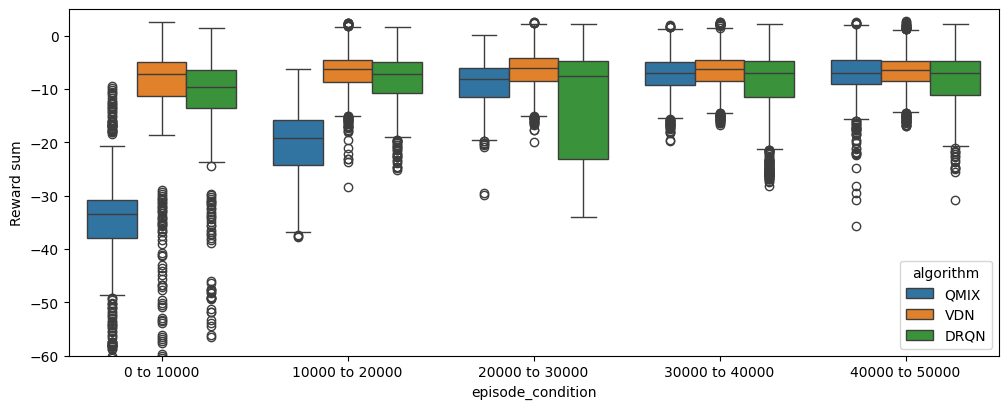

In [8]:
plt.figure(figsize=(12.0, 4.5))
sns.boxplot(concat_df[concat_df['agent_hindered'] != 'None'], y='Reward sum', x='episode_condition',
                hue='algorithm', fill=True)
plt.ylim([-60.0, 5.0])
plt.show()